In [4]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import math
from random import choice

from datetime import datetime
from datetime import timedelta

from statsmodels.tsa.arima.model import ARIMA 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

import pmdarima
from pmdarima.arima.utils import ndiffs

In [5]:
trading_portfolio = pd.ExcelFile('trading_portfolio.xlsx')
trading_portfolio #load the Excel file with data from all the sheets

In [6]:
trading_portfolio.sheet_names # output of this is a list of all the sheets within the Excel file
# therefore, you can loop through the sheet names and load them into dataframes individually

['Russia - Sberbank Rossii PAO (S',
 'Turkey - Koc Holding AS (KCHOL)',
 'Egypt - Medinet Nasr Housing (M',
 'Brazil - Minerva SABrazil (BEEF',
 'Argentina - Pampa Energia SA (P',
 'Colombia - Cementos Argos SA (C',
 'South Africa - Impala Platinum ',
 'South Korea - Dongkuk Steel Mil']

## Read one company stock info into a dataframe

In [7]:
# read one of the excel file sheets into a dataframe
df = pd.read_excel('trading_portfolio.xlsx', sheet_name = trading_portfolio.sheet_names[1])

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316 entries, 0 to 315
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      316 non-null    object 
 1   Price     316 non-null    object 
 2   Open      316 non-null    object 
 3   High      316 non-null    object 
 4   Low       316 non-null    object 
 5   Vol.      315 non-null    object 
 6   Change %  315 non-null    float64
dtypes: float64(1), object(6)
memory usage: 17.4+ KB


## Data cleaning

In [9]:
df = df[:-1].copy() #drop the last row by slicing and create a deep copy so that subsequent changes will not throw the warning
# 'A value is trying to be set on a copy of a slice from a DataFrame...'

In [10]:
# convert date from string object to datetime format

df['Date'] = pd.to_datetime(df['Date'])

In [11]:
# several of the columns are string objects. Convert to numeric
df[['Price','Open', 'High', 'Low', 'Change %']] = df[['Price','Open', 'High', 'Low', 'Change %']].apply(pd.to_numeric)

In [12]:
df['Vol.'] = df['Vol.'].apply(lambda x: x[:-1]).astype('float32') # for the volume column remove M (for millions)
# and then convert to float32 and normalize to the maximum

In [13]:
df.tail()

,Date,Price,Open,High,Low,Vol.,Change %
310,2020-01-08,19.94,19.89,19.95,19.66,2.79,0.0005
311,2020-01-07,19.93,20.22,20.28,19.92,2.89,-0.0075
312,2020-01-06,20.08,20.34,20.34,19.97,1.94,-0.0108
313,2020-01-03,20.30,20.30,20.44,19.97,3.31,-0.0039
314,2020-01-02,20.38,20.42,20.44,20.24,2.53,0.0030


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 315 entries, 0 to 314
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      315 non-null    datetime64[ns]
 1   Price     315 non-null    float64       
 2   Open      315 non-null    float64       
 3   High      315 non-null    float64       
 4   Low       315 non-null    float64       
 5   Vol.      315 non-null    float32       
 6   Change %  315 non-null    float64       
dtypes: datetime64[ns](1), float32(1), float64(5)
memory usage: 16.1 KB


## Plot the stock price vs the date in 2020 and 2021

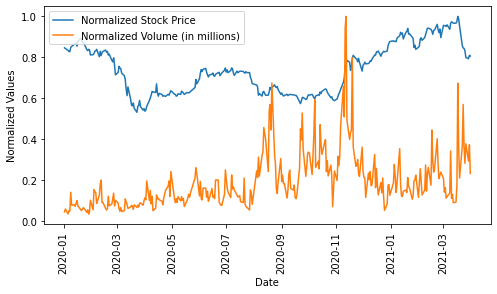

In [15]:
# plot the 'Price' and 'Vol.' columns, both normalized to their maximum values (so as to observe if there are trends between
# the stock price and the volume)
plt.figure(figsize = (8,4))
sns.lineplot(x = df['Date'], y = df['Price']/df['Price'].max())
sns.lineplot(x = df['Date'], y = df['Vol.']/df['Vol.'].max())
plt.xticks(rotation= 90)
plt.ylabel('Normalized Values')
plt.legend(loc = 'upper left', labels= ['Normalized Stock Price','Normalized Volume (in millions)'])
plt.show()
#there is no clear trend. Some increases in the price (between 2020-11 and 2021-01) is preceded by large transaction volumes
# while others (e.g. between 2020-4 and 2020-6) is not. 
# So transaction volumnes may not be a good indicator of a subsequent increase in stock prices

# 1) Predicting daily stock prices

## Create training and testing data from closing stock prices
## All prices from 2020 - > Training
## All prices from 2021 -> testing

In [16]:
# for the dataset, we will use all Q1 - Q4 data from 2020 for training and Q1 data from 2021 as testing
# select 2021 Q1 data as follows
# select just the Price column and convert values to a list form
X_test = list(df[pd.DatetimeIndex(df['Date']).year == 2021]['Price'].values)
X_test[:20]#truncated display

[19.41,
 19.5,
 19.1,
 19.25,
 20.02,
 20.32,
 20.36,
 20.66,
 22.94,
 23.78,
 24.08,
 23.48,
 23.28,
 23.28,
 23.36,
 23.44,
 23.26,
 22.56,
 23.08,
 22.9]

In [17]:
# likewise, selecte all data from 2020 for training the model
X_train = list(df[pd.DatetimeIndex(df['Date']).year == 2020]['Price'].values)
X_train[:20] #truncated display

[21.12,
 20.94,
 20.62,
 20.0,
 19.9,
 19.97,
 19.84,
 19.68,
 19.39,
 20.0,
 19.89,
 19.91,
 19.52,
 19.54,
 19.05,
 18.8,
 18.85,
 18.62,
 18.53,
 18.49]

In [18]:
len(X_train), len(X_test)

(252, 63)

## Establish stationarity - second order differencing

In [19]:
from statsmodels.tsa.stattools import adfuller #import Augmented Dickey-Fuller Test

In [20]:
adfuller(df['Price']) # the p- value of 0.66 is greater than > 0.05 and therefore we reject the null hypothesis. 
# i.e. the raw stock price data is non-stationary

(-1.2277840487902,
 0.6615309995716299,
 0,
 314,
 {'1%': -3.4513486122290717,
  '5%': -2.870789013306053,
  '10%': -2.5716978530569192},
 317.71892646215963)

In [21]:
adfuller(df['Price'].diff().dropna()) # the p-value after first order differencing is less than 0.05 and therefore we can consider
# the data to be stationary
# p-value for second order differencing is also less than 0.05 (not shown)
# this indicates either first or second order differencing can be used in our ARIMA model

(-17.041138470687216,
 8.19472533124018e-30,
 0,
 313,
 {'1%': -3.4514162625887037,
  '5%': -2.8708187088091406,
  '10%': -2.5717136883095675},
 318.21855366762725)

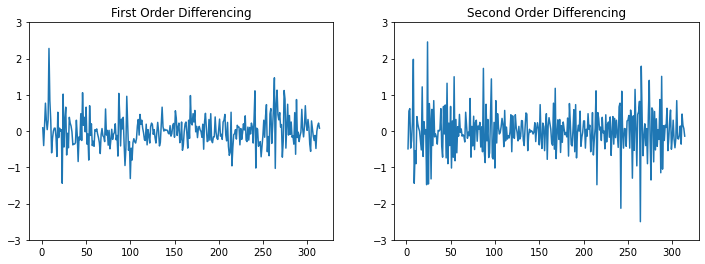

In [22]:
# PLot daily stock prices after first or second order differencing
fig, axes = plt.subplots(1, 2, figsize = (12,4))
axes[0].plot(df['Price'].diff().dropna())
axes[0].set_title('First Order Differencing')
axes[0].set_ylim([-3,3])
axes[1].plot(df['Price'].diff().diff().dropna())
axes[1].set_title('Second Order Differencing')
axes[1].set_ylim([-3,3])
plt.show()
# both differencing techniques result in stationarity around 0. But noise is significantly larger after second order differencing
# it seems that first order differencing (d =1) can be used tentatively as a starting point

In [23]:
# You can also determine the optimal differencing order using the pmdarima package (already imported above)
# and running the following line of code
ndiffs(df['Price'], test='adf') # here 'adf' refers to Augmented Dickie-Fuller Test to test for stationarity
# This method also indicates that the ideal differencing order is 1, not 2

1

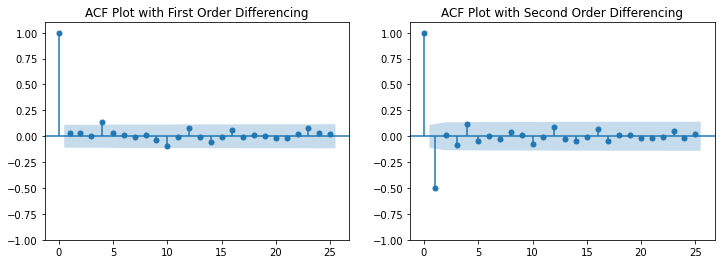

In [24]:
# Plot autocorrelation for the first and second order differencing
fig, axes = plt.subplots(1, 2, figsize = (12,4))
plot_acf(df['Price'].diff().dropna(), ax = axes[0])
axes[0].set_title('ACF Plot with First Order Differencing')
axes[0].set_ylim([-1,1.1])
plot_acf(df['Price'].diff().diff().dropna(), ax = axes[1])
axes[1].set_title('ACF Plot with Second Order Differencing')
axes[1].set_ylim([-1,1.1])
plt.show()
# With second order differencing, the first lag goes into the far negative correlation quickly likely indicating
# over-differencing. So our selection of first order differencing (d=1) is confirmed here as well.
# With first order differencing, the first positive correlation (i.e. first lag that is above the threshold)
# is at 4. So we will tentatively select q = 4 which the error term for the moving average (MA)

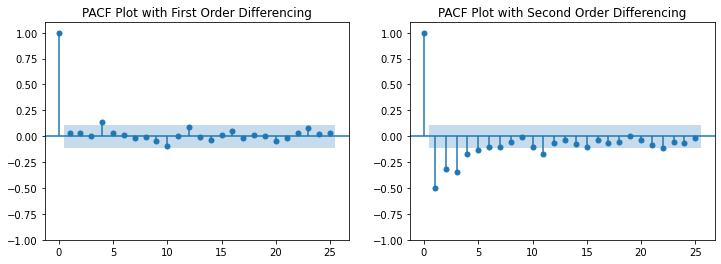

In [25]:
# Plot partial autocorrelation for the first and second order differencing
fig, axes = plt.subplots(1, 2, figsize = (12,4))
plot_pacf(df['Price'].diff().dropna(), ax = axes[0], method='ywm')
axes[0].set_title('PACF Plot with First Order Differencing')
axes[0].set_ylim([-1,1.1])
plot_pacf(df['Price'].diff().diff().dropna(), ax = axes[1], method='ywm')
axes[1].set_title('PACF Plot with Second Order Differencing')
axes[1].set_ylim([-1,1.1])
plt.show()
# We see here again the with second order differencing, the lags go into the negative correlation quickly
# We will therefore stick with the first order differencing.
# With first order differencing, the first lag that indicates positive correlation is at 4
# We will therefore select p = 4 initially

In [26]:
# Prepare the ARIMA model again for training but using different p, d and q values

model_predictions = []
num_test_obser = len(X_test)

for i in range(num_test_obser):
    model = ARIMA(X_train, order = (3, 1, 1)) # where p = 3 which is the number of lag observations, 
                                              #  d = 1 which is the number of times the raw observations are differenced to make the tren stationary
                                              # q = 1 which is the size of the moving average window
    model_fit =  model.fit()
    output = model_fit.forecast()
    
    model_predictions.append (output[0]) # append the predicted value to the model_predictions list
    
    true_test_value = X_test[i] # the corresponding test value of the X_test list
    X_train.append(true_test_value) # update the training dataset by appending the true_test_value. 
                                    # This will be used in the next training round
    

In [27]:
print(model_fit.summary())#model summary

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  314
Model:                 ARIMA(3, 1, 1)   Log Likelihood                -182.141
Date:                Thu, 04 Aug 2022   AIC                            374.282
Time:                        15:32:07   BIC                            393.013
Sample:                             0   HQIC                           381.768
                                - 314                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6102      0.627     -0.973      0.330      -1.839       0.619
ar.L2          0.0515      0.062      0.826      0.409      -0.071       0.174
ar.L3         -0.0203      0.074     -0.273      0.7

<AxesSubplot:xlabel='Date'>

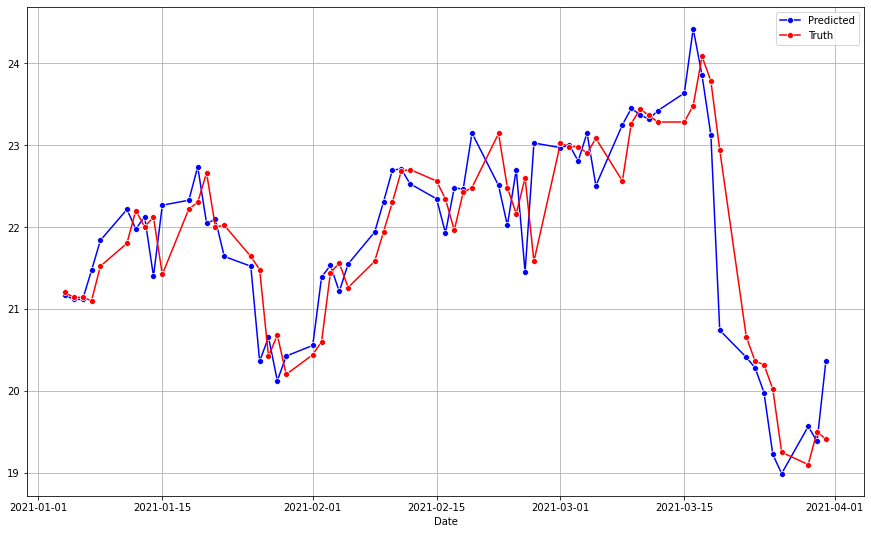

In [28]:
# plot the predicted and truth values

plt.figure(figsize = (15, 9))
plt.grid(True)

date_range = df[pd.DatetimeIndex(df['Date']).year == 2021]['Date'] # dates of the test data used for graph's X_axis
sns.lineplot(x=date_range, y=model_predictions, color = 'blue', marker = 'o', label = 'Predicted')
sns.lineplot(x=date_range, y=X_test, color = 'red', marker = 'o', label = 'Truth')
#there is an offset of one day between Predicted and Truth values

In [29]:
# calculate the error metrics for model_fit
MAE = mean_absolute_error(model_predictions, X_test)
MSE = mean_squared_error(model_predictions, X_test)
MAPE = mean_absolute_percentage_error(model_predictions, X_test)
print('Mean Absolute Error :', MAE)
print('Mean Squared Error :', MSE)
print('Mean Absolute Percentage Error :', MAPE)

Mean Absolute Error : 0.4103732086234479
Mean Squared Error : 0.31730258270693057
Mean Absolute Percentage Error : 0.018900147075461757


In [31]:
# Use auto_arima method from pmdarima to automatically determine the optimal values of p,d and q

model2 = pmdarima.auto_arima(X_train, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=4, max_q=4, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model2.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=372.587, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=369.941, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=371.644, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=371.662, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=367.941, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.477 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  315
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -182.971
Date:                Thu, 04 Aug 2022   AIC                            367.941
Time:                        15:32:08   BIC                            371.691
Sample:                             0   HQIC                           369.439
                                - 315                                         
Co

In [32]:
# use the automatically determined p, d and q values to train another ARIMA model

model2_predictions = []
num_test_obser = len(X_test)

for i in range(num_test_obser):
    model2 = ARIMA(X_train, order = (0, 1, 0)) # where p = 0 which is the number of lag observations, 
                                              #  d = 1 which is the number of times the raw observations are differenced to make them stationary
                                              # q = 0 which is the size of the moving average window
    model2_fit =  model2.fit()
    output2 = model2_fit.forecast()
    
    model2_predictions.append (output2[0]) # append the predicted value to the model2_predictions list
    
    true_test_value = X_test[i] # the corresponding test value of the X_test list
    X_train.append(true_test_value)

In [147]:
model2_predictions[:10]

[21.2,
 19.41,
 19.5,
 19.1,
 19.25,
 20.02,
 20.32,
 20.36,
 20.66,
 22.939999999999998]

In [148]:
X_test[:10]

[19.41, 19.5, 19.1, 19.25, 20.02, 20.32, 20.36, 20.66, 22.94, 23.78]

<AxesSubplot:xlabel='Date'>

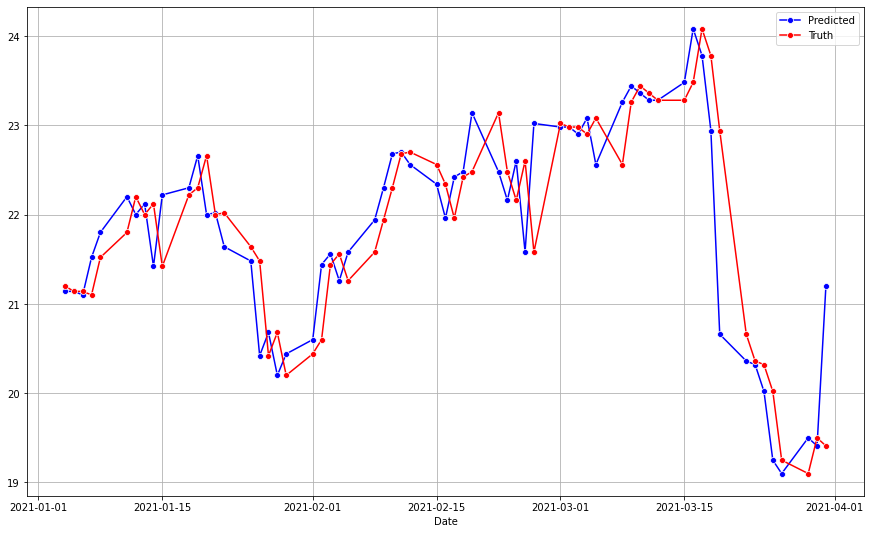

In [33]:
# plot the predicted and truth values

plt.figure(figsize = (15, 9))
plt.grid(True)

date_range = df[pd.DatetimeIndex(df['Date']).year == 2021]['Date'] # dates of the test data used for graph's X_axis
sns.lineplot(x=date_range, y=model2_predictions, color = 'blue', marker = 'o', label = 'Predicted')
sns.lineplot(x=date_range, y=X_test, color = 'red', marker = 'o', label = 'Truth')
#there is an offset of one day between Predicted and Truth values

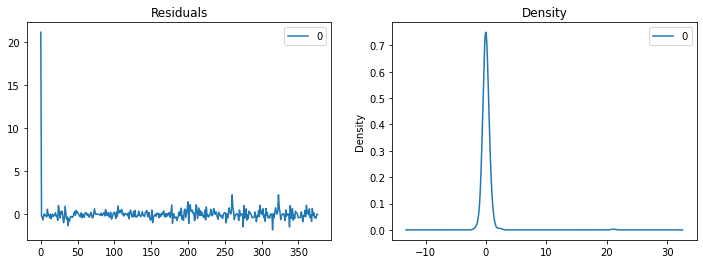

In [34]:
residuals = pd.DataFrame(model2_fit.resid)
fig, axes = plt.subplots(1,2, figsize=(12,4))
residuals.plot(title="Residuals", ax=axes[0])
residuals.plot(kind='kde', title='Density', ax=axes[1])
plt.show()
# the residual errors have a mean of 0 and variance that is tightly and normally distributed around mean of 0

In [35]:
# calculate the error metrics for model2_fit
MAE = mean_absolute_error(model2_predictions, X_test)
MSE = mean_squared_error(model2_predictions, X_test)
MAPE = mean_absolute_percentage_error(model2_predictions, X_test)
print('Mean Absolute Error :', MAE)
print('Mean Squared Error :', MSE)
print('Mean Absolute Percentage Error :', MAPE)
# these metrics are very similar to those of the first model (model_fit)

Mean Absolute Error : 0.4015873015873014
Mean Squared Error : 0.33786666666666665
Mean Absolute Percentage Error : 0.018513545653157916


## How effective is random trading in helping to make money?
## Random trading can then be compared to how well an ARIMA model will perform

In [ ]:
#specify starting and ending dates (this is the data available from 2021 that can be used in simulations)
starting_date = df[pd.DatetimeIndex(df['Date']).year == 2021]['Date'].min()
ending_date = df[pd.DatetimeIndex(df['Date']).year == 2021]['Date'].max()

In [102]:
#define functions for buying or selling shares. It is assumed that trading commissions are not charged for buying or selling

# for buying shares
def buy_shares(capital_available, share_price): # assume no commissions for buying
    """ Input: capital available to buy shares at the specified share price
        Output: the number of whole shares bought and the balance available after the purchase
    """
    num_shares_bought = int(capital_available/share_price)
    money_left = capital_available - (num_shares_bought* share_price)
    return num_shares_bought, round(money_left,2)


#for selling shares
def sell_shares (num_shares, share_price): # assume no commisions for selling
    """ Input:  tnumber of shares to be sold at the specified share price
        Output: the total proceeds from the sale
    """
    proceeds = num_shares * share_price
    return round(proceeds,2)

In [78]:
# following block of code loops through all the dates between starting and ending dates for each run of random trades.

def run_simulation(num_cycles, starting_capital):
    
    starting_capital = starting_capital
    
    #specify a dictionary to store the total number of cycles, ending capital of after each cycle and loss/gain after each cycle
    end_capital = {'num':0,
                   'tot_capital':[],
                   'loss_gain':[]}
    
    for cycle in range (num_cycles):
        
    
        for i in (df[pd.DatetimeIndex(df['Date']).year == 2021]['Date'][::-1]):
            if i == starting_date:
                choose_trade = 'buy'
                num_shares_bought, money_left = buy_shares(starting_capital, df[df['Date'] == i]['Price'].iloc[0])
                #print('First', choose_trade, num_shares_bought, money_left)

            elif i == ending_date:

                if choose_trade == 'buy': # if the previous to last date was a 'buy', then sell the shares
                    proceeds = sell_shares(num_shares_bought, df[df['Date'] == i]['Price'].iloc[0])
                    ending_capital = round(proceeds+money_left, 2)
                    loss_or_gain = round(ending_capital - starting_capital, 2)
                    #print('Last a', ending_capital, loss_or_gain)
                    
                    end_capital['num']+=1
                    end_capital['tot_capital'].append(ending_capital)
                    end_capital['loss_gain'].append(loss_or_gain)
                    
                elif choose_trade == 'sell': # if previous to last was a 'sell', then ending capital is the money_left
                    ending_capital = money_left
                    loss_or_gain = round(ending_capital - starting_capital, 2)
                    #print('Last b', ending_capital, loss_or_gain)
                    
                    end_capital['num']+=1
                    end_capital['tot_capital'].append(ending_capital)
                    end_capital['loss_gain'].append(loss_or_gain)

                else: # if previous to last was a 'hold', then sell
                    ending_capital = sell_shares (num_shares_bought,df[df['Date'] == i]['Price'].iloc[0])
                    loss_or_gain = round(ending_capital - starting_capital, 2)
                    #print('Last c', ending_capital, loss_or_gain)
                    
                    end_capital['num']+=1
                    end_capital['tot_capital'].append(ending_capital)
                    end_capital['loss_gain'].append(loss_or_gain)

            elif choose_trade == 'buy':
                choose_trade = choice(sh) 
                if choose_trade == 'sell':
                    money_left+= sell_shares(num_shares_bought, df[df['Date'] == i]['Price'].iloc[0])
                    #print ('3a', choose_trade, round(money_left,2))        
                else:
                    #print('3b', choose_trade, round(money_left,2))
                    continue

            elif choose_trade == 'sell':
                choose_trade = 'buy'
                num_shares_bought, money_left = buy_shares (money_left, df[df['Date'] == i]['Price'].iloc[0])
                #print ('4', choose_trade, num_shares_bought, round(money_left,2))

            else:
                choose_trade =  choice (sh)
                if choose_trade == 'sell':
                    money_left += sell_shares(num_shares_bought, df[df['Date'] == i]['Price'].iloc[0])
                    #print('5a', choose_trade, round(money_left,2))
                else:
                    #print('5b', choose_trade, round(money_left,2))
                    continue
                    
    return end_capital        

In [82]:
# run the above simulation many times (say 1000) with a starting capital of $1000 (or the currency of the share price)

dict_1 = run_simulation(2000, 1000) #run 200- simulations with $1000 in each simulation

ending_capital = round(np.array(dict_1['tot_capital']).mean(), 2)
ending_loss_gain = round(np.array(dict_1['loss_gain']).mean(), 2)

ending_capital, ending_loss_gain

(942.4, -57.6)

Text(0.5, 1.0, 'Random Buy, Sell or Hold')

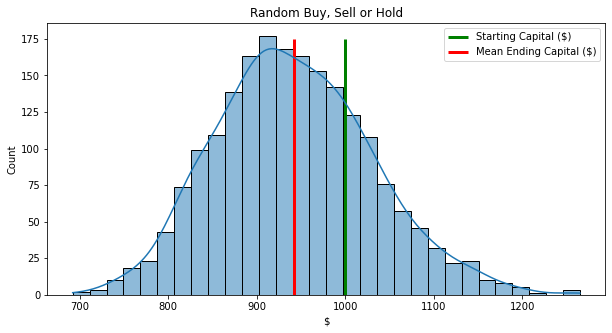

In [103]:
# plot the distribution of the capital left at the end after running the random trade simulation (e.g.1000 times)
plt.figure(figsize=(10,5))
sns.histplot(data = dict_1, x=dict_1['tot_capital'], bins = 30, kde=True)
plt.vlines(x=1000, ymin = 0, ymax=175, color='g', linewidth=3, label = 'Starting Capital ($)')
plt.vlines(x=np.array(dict_1['tot_capital']).mean(), ymin = 0, ymax=175, color='r', linewidth=3, label = 'Mean Ending Capital ($)')
plt.legend()
plt.xlabel('$')
plt.title('Random Buy, Sell or Hold')

## All code below, work in progress

In [110]:
X_train = list(df[pd.DatetimeIndex(df['Date']).year == 2020]['Price'].values)
X_test = list(df[pd.DatetimeIndex(df['Date']).year == 2021]['Price'].values)

In [111]:
len(X_train), len(X_test)

(252, 63)

In [118]:
# make deep copies of the training and testing data
X_train_2 = X_train.copy()
X_test_2 = X_test.copy()

In [127]:
X_test.index(X_test[-1])

62

In [159]:
X_train_2 = X_train.copy()
X_test_2 = X_test.copy()

num_test_obser = len(X_test_2)

starting_capital = 1000
threshold = 0.0001 # threshold difference from today's share price for buying or selling a stock

position = 0 # position = 0, does not own shares, position = 1 own shares

num_shares_bought = 0

model_preds = []

for i in range(num_test_obser):
    model_test = ARIMA(X_train_2, order = (0, 1, 0)) # where p = 0 which is the number of lag observations, 
                                              #  d = 1 which is the number of times the raw observations are differenced to make them stationary
                                              # q = 0 which is the size of the moving average window
    model_test_fit =  model_test.fit()
    output_test = model_test_fit.forecast()
    
    model_preds.append(output_test[0])
    
    print('round :', i)  
    if i == 0:
        
        if output_test[0] > X_train_2[-1]*threshold: # on the first day is the prediction for next day is greater than 
            # current day price*threshold, then BUY shares
            num_shares_bought, money_left = buy_shares(starting_capital, X_train_2[-1]) 
            position = 1 # set position to 1 indicating owning shares
            print('1a', output_test[0], X_train_2[-1], num_shares_bought, money_left)

        elif output_test[0] < X_train_2[-1]*threshold:# on the first day if the predicted share price for next day is less but
            # there is nothing to sell today, HOLD in cash
            money_left = starting_capital 
            print('1b', output_test[0], X_train_2[-1], num_shares_bought, money_left)
            
    elif output_test[0] > X_train_2[-1]*threshold and position ==0: #if next day's prediction is greater than today's*threshold
        # and no shares are owned, BUY shares
        capital =  money_left
        num_shares_bought, money_left = buy_shares(capital, X_train_2[-1])
        position = 1
        print('2', output_test[0], X_train_2[-1], num_shares_bought, money_left)
    
    elif output_test[0] > X_train_2[-1]*threshold and position ==1: #if next day's prediction is greater than today's*threshold
        # but you already own shares, HOLD (nothing else you can do)
        print('3', output_test[0], X_train_2[-1], num_shares_bought, money_left)

    elif output_test[0] < X_train_2[-1]*threshold and position ==0: #if next day's prediction is less than today's*threshold
        # and no shares are owned, HOLD
        print('4', output_test[0], X_train_2[-1], num_shares_bought, money_left)

    elif output_test[0] < X_train_2[-1]*threshold and position ==1: #if next day's prediction is less than today's*threshold
        # and you own shares, SELL
        money_left+= sell_shares(num_shares_bought, X_train_2[-1])
        position = 0
        print('5', output_test[0], X_train_2[-1], num_shares_bought, money_left)
    
    true_test_value = X_test_2[i] # the corresponding test value of the X_test list
    X_train_2.append(true_test_value)

print(X_train_2)
print(X_test_2)


round : 0
1a 21.2 21.2 47 3.6
round : 1
3 19.41 19.41 47 3.6
round : 2
3 19.5 19.5 47 3.6
round : 3
3 19.1 19.1 47 3.6
round : 4
3 19.25 19.25 47 3.6
round : 5
3 20.02 20.02 47 3.6
round : 6
3 20.32 20.32 47 3.6
round : 7
3 20.36 20.36 47 3.6
round : 8
3 20.66 20.66 47 3.6
round : 9
3 22.94 22.94 47 3.6
round : 10
3 23.78 23.78 47 3.6
round : 11
3 24.08 24.08 47 3.6
round : 12
3 23.48 23.48 47 3.6
round : 13
3 23.28 23.28 47 3.6
round : 14
3 23.28 23.28 47 3.6
round : 15
3 23.36 23.36 47 3.6
round : 16
3 23.44 23.44 47 3.6
round : 17
3 23.26 23.26 47 3.6
round : 18
3 22.56 22.56 47 3.6
round : 19
3 23.08 23.08 47 3.6
round : 20
3 22.9 22.9 47 3.6
round : 21
3 22.98 22.98 47 3.6
round : 22
3 22.98 22.98 47 3.6
round : 23
3 23.02 23.02 47 3.6
round : 24
3 21.58 21.58 47 3.6
round : 25
3 22.6 22.6 47 3.6
round : 26
3 22.16 22.16 47 3.6
round : 27
3 22.48 22.48 47 3.6
round : 28
3 23.14 23.14 47 3.6
round : 29
3 22.48 22.48 47 3.6
round : 30
3 22.42 22.42 47 3.6
round : 31
3 21.96 21.96 47

In [150]:
model_preds[:10]

[21.171304832143143,
 19.41099320657066,
 19.355858874623763,
 19.21741367268676,
 19.12368470844049,
 20.136587055171745,
 20.294533101858683,
 20.408660239170466,
 20.628435239308246,
 23.041225183966972]

In [151]:
X_test_2[:10]

[19.41, 19.5, 19.1, 19.25, 20.02, 20.32, 20.36, 20.66, 22.94, 23.78]

# Predicting average monthly stock prices

In [33]:
# extract monthly average stock prices and save in train or test lists

month_train = []
month_test = []

for i in range (1,13):
    month_train.append(df[(pd.DatetimeIndex(df['Date']).year == 2020) & (pd.DatetimeIndex(df['Date']).month == i)]['Price'].mean())
    month_test.append(df[(pd.DatetimeIndex(df['Date']).year == 2021) & (pd.DatetimeIndex(df['Date']).month == i)]['Price'].mean())
    
#remove null values from a list if a month is missing (especially true for months in an incomplete year e.g. 2021)
month_train = [x for x in month_train if str(x) !='nan']
month_test = [x for x in month_test if str(x) != 'nan']


In [34]:
# run an ARIMA model for predicting the monthly average stock price 

month_predictions = []
month_test_obser = len(month_test)

for i in range(month_test_obser):
    model_month = ARIMA(month_train, order = (2, 1, 2)) # where p = 10 which is the number of lag observations, 
                                              #  d = 1 which is the number of times the raw observations are differenced to make the tren stationary
                                              # q = 0 which is the size of the moving average window
    model_month_fit =  model_month.fit()
    output_month = model_month_fit.forecast()
    
    month_predictions.append (output_month[0]) # append the predicted value to the model_predictions list
    
    month_test_value = month_test[i] # the corresponding test value of the month_test list
    month_train.append(month_test_value) # update the training dataset by appending the true_test_value. 
                                    # This will be used in the next training round

C:\Users\Manj\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:965: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Manj\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:977: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Manj\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [35]:
print(model_month_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   14
Model:                 ARIMA(2, 1, 2)   Log Likelihood                 -22.688
Date:                Mon, 01 Aug 2022   AIC                             55.376
Time:                        22:02:01   BIC                             58.201
Sample:                             0   HQIC                            54.796
                                 - 14                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4525      0.440      1.029      0.303      -0.409       1.314
ar.L2         -0.6360      0.586     -1.085      0.278      -1.785       0.513
ma.L1          0.2684     50.016      0.005      0.9

<AxesSubplot:>

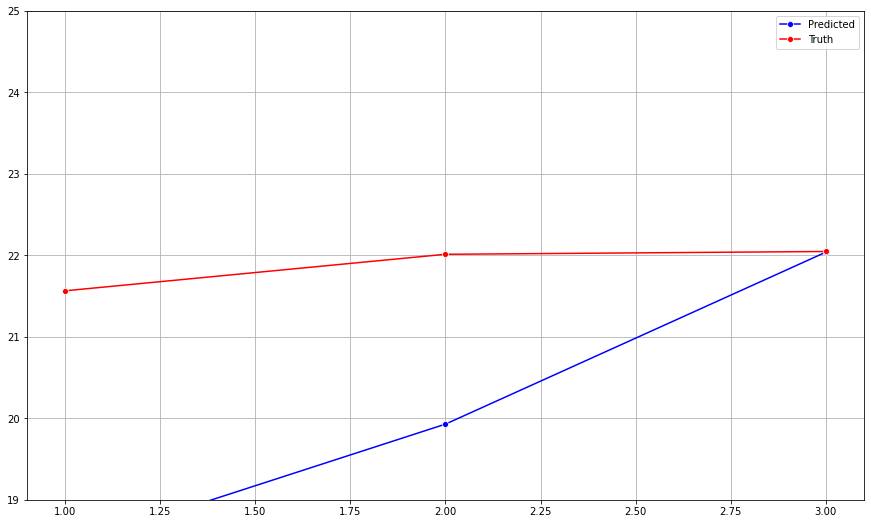

In [36]:
plt.figure(figsize = (15, 9))
plt.grid(True)
plt.ylim(ymin=19, ymax=25)

month_range = [1,2,3]

sns.lineplot(x=month_range, y=month_predictions, color = 'blue', marker = 'o', label = 'Predicted')
sns.lineplot(x=month_range, y=month_test, color = 'red', marker = 'o', label = 'Truth')

# Predicting weekly stock prices

In [37]:
import warnings
warnings.filterwarnings('ignore')
# ignore warnings for the following lines of code for week determination

In [38]:
# extract the weekly stock price averages for training and testing data
week_train = []
week_test = []

for i in range (1,54):
    week_train.append(df[(pd.DatetimeIndex(df['Date']).year == 2020) & (pd.DatetimeIndex(df['Date']).week == i)]['Price'].mean())
    week_test.append(df[(pd.DatetimeIndex(df['Date']).year == 2021) & (pd.DatetimeIndex(df['Date']).week == i)]['Price'].mean())
    
#remove null values from the list if a week is missing (especially true for weeks in an incomplete year, e.g. 2021)
week_train = [x for x in week_train if str(x) !='nan']
week_test = [x for x in week_test if str(x) != 'nan']

In [39]:
# run an ARIMA model for preciting average weekly stock price
week_predictions = []
week_test_obser = len(week_test)

for i in range(week_test_obser):
    model_week = ARIMA(week_train, order = (2, 1, 2)) # where p = 10 which is the number of lag observations, 
                                              #  d = 1 which is the number of times the raw observations are differenced to make the tren stationary
                                              # q = 0 which is the size of the moving average window
    model_week_fit =  model_week.fit()
    output_week = model_week_fit.forecast()
    
    week_predictions.append (output_week[0]) # append the predicted value to the model_predictions list
    
    week_test_value = week_test[i] # the corresponding test value of the month_test list
    week_train.append(week_test_value) # update the training dataset by appending the true_test_value. 
                                    # This will be used in the next training round

In [40]:
print(model_week_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   65
Model:                 ARIMA(2, 1, 2)   Log Likelihood                 -80.094
Date:                Mon, 01 Aug 2022   AIC                            170.188
Time:                        22:02:06   BIC                            180.983
Sample:                             0   HQIC                           174.441
                                 - 65                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5639      1.928     -0.293      0.770      -4.342       3.215
ar.L2          0.1358      1.115      0.122      0.903      -2.050       2.321
ma.L1          1.0179      4.443      0.229      0.8

<AxesSubplot:>

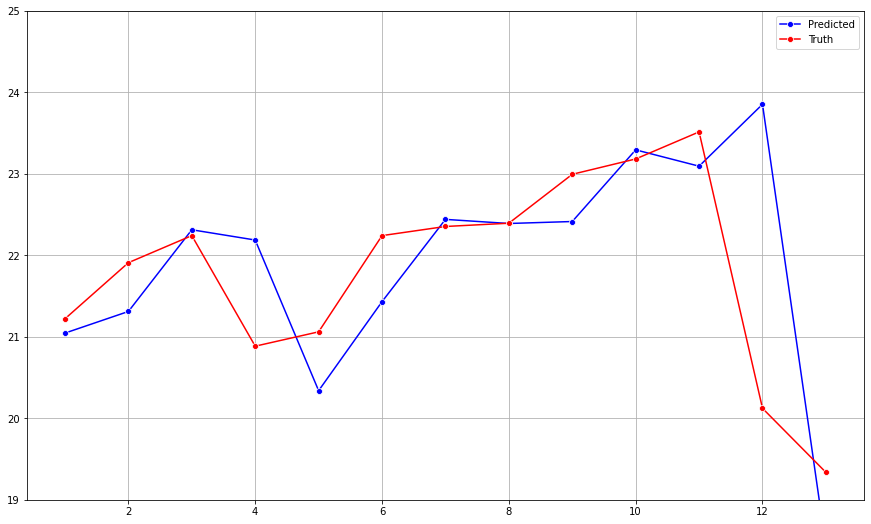

In [41]:
plt.figure(figsize = (15, 9))
plt.grid(True)
plt.ylim(ymin=19, ymax=25)

week_range = [1,2,3,4,5,6,7,8,9,10,11,12,13]

sns.lineplot(x=week_range, y=week_predictions, color = 'blue', marker = 'o', label = 'Predicted')
sns.lineplot(x=week_range, y=week_test, color = 'red', marker = 'o', label = 'Truth')